In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import tensorflow as tf


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Import data

In [0]:
train = pd.read_csv('/content/updated_train.csv')
test=pd.read_csv('/content/updated_test.csv')
ss=pd.read_csv('/content/updated_ss.csv')

# Exploratory data analysis 

In [0]:
ss.head()

,ID,target
0,test_2,0
1,test_3,0
2,test_4,0
3,test_8,0
4,test_9,0


In [0]:
ss.target=ss.target.replace(0,0.7)

In [0]:
ss.head()

,ID,target
0,test_2,0.7
1,test_3,0.7
2,test_4,0.7
3,test_8,0.7
4,test_9,0.7


In [0]:
train.describe()

,target
count,5287.000000
mean,0.480613
std,0.499671
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [0]:
train.isnull().sum(axis=1)

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
5262    0
5263    0
5264    0
5265    0
5266    0
5267    0
5268    0
5269    0
5270    0
5271    0
5272    0
5273    0
5274    0
5275    0
5276    0
5277    0
5278    0
5279    0
5280    0
5281    0
5282    0
5283    0
5284    0
5285    0
5286    0
Length: 5287, dtype: int64

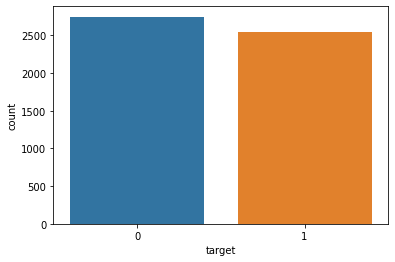

In [0]:
sns.countplot(train.target)


# Defining model

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,Conv1D,MaxPooling1D
from keras.datasets import imdb

In [0]:
lenghts=[]
for text in train.text:
  lenghts.append(len(text))

In [0]:
embedding_dim = 100
max_length = max(lenghts)
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
test_portion=.1

corpus = []

In [7]:
tranc=train
tranc=tranc.drop(columns=['ID'])
tranc

,text,target
0,The bitcoin halving is cancelled due to,1
1,MercyOfAllah In good times wrapped in its gran...,0
2,266 Days No Digital India No Murder of e learn...,1
3,India is likely to run out of the remaining RN...,1
4,In these tough times the best way to grow is t...,0
...,...,...
5282,The spread of the novel among asylum seekers o...,1
5283,Hundreds of Jewish patients are being treated...,1
5284,Beats me Honestly most of the people I follow ...,0
5285,Help us reach more people by donating and shar...,0


In [0]:
t=tranc.values

In [9]:
corpus=[]
l=list(t)
for e in l :
  corpus.append(e)
corpus[0]

array(['The bitcoin halving is cancelled due to', 1], dtype=object)

In [0]:
train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


# Tokenizing data


In [0]:
import random
sentences=[]
labels=[]
random.shuffle(corpus)
training_size=train.shape[0]
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = labels[0:split]
training_labels = labels[split:training_size]

In [0]:
test_sequences=np.array(test_sequences)
training_sequences=np.array(training_sequences)
test_labels=np.array(test_labels)
training_labels=np.array(training_labels)

# Creating 100 dimensions embeddings with GloVe

In [12]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-05-09 23:13:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   103MB/s    in 3.2s    

2020-05-09 23:13:04 (103 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [29]:
embeddings_matrix.shape

(14329, 100)

# Our model

In [19]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.2))

model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 302, 100)          1432900   
_________________________________________________________________
dropout_1 (Dropout)          (None, 302, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 64)           32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 74, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,531,141
Trainable params: 98,241
Non-trainable params: 1,432,900
_______________________________________

In [20]:
num_epochs = 10

history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

Train on 4759 samples, validate on 528 samples
Epoch 1/10
4759/4759 [==============================] - 38s 8ms/step - loss: 0.4599 - accuracy: 0.7878 - val_loss: 0.3535 - val_accuracy: 0.8561
Epoch 2/10
4759/4759 [==============================] - 37s 8ms/step - loss: 0.3453 - accuracy: 0.8485 - val_loss: 0.2948 - val_accuracy: 0.8845
Epoch 3/10
4759/4759 [==============================] - 37s 8ms/step - loss: 0.3069 - accuracy: 0.8678 - val_loss: 0.2442 - val_accuracy: 0.9129
Epoch 4/10
4759/4759 [==============================] - 38s 8ms/step - loss: 0.2624 - accuracy: 0.8886 - val_loss: 0.2167 - val_accuracy: 0.9186
Epoch 5/10
4759/4759 [==============================] - 37s 8ms/step - loss: 0.2191 - accuracy: 0.9141 - val_loss: 0.2036 - val_accuracy: 0.9299
Epoch 6/10
4759/4759 [==============================] - 37s 8ms/step - loss: 0.1827 - accuracy: 0.9298 - val_loss: 0.2061 - val_accuracy: 0.9186
Epoch 7/10
4759/4759 [==============================] - 37s 8ms/step - loss: 0.1600

In [0]:



tokenizer = Tokenizer()
tokenizer.fit_on_texts(test_sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(test_sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


test_sequences = padded


In [0]:
test_sentences=[]
test_sentences=test.text.to_list()


In [0]:
test_sequences=np.array(test_sequences)


In [0]:
predict=model.predict(test_sequences)

In [0]:
list1 = predict.tolist()

# Creating submission

In [0]:
submission = pd.DataFrame({"ID": ss["ID"],

"target": list1

})

submission.to_csv("submission.csv", index = False)